In [1]:
import jax

import jax.numpy as np
import jax.scipy as sp

from numpy.polynomial.hermite import hermgauss
import scipy as osp

from vb_lib import structure_model_lib, data_utils, cavi_lib
from vb_lib.preconditioner_lib import get_mfvb_cov_matmul

import paragami
import vittles

from copy import deepcopy

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib
from bnpmodeling_runjingdev.sensitivity_lib import get_jac_hvp_fun

/home/rliu/anaconda3/envs/bnp_sensitivity_jax/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
import numpy as onp
onp.random.seed(53453)

# Draw data

In [3]:
n_obs = 100
n_loci = 2000
n_pop = 4

In [4]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

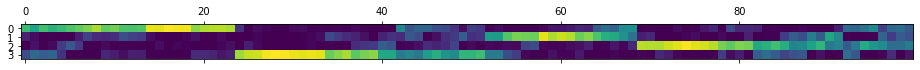

In [5]:
plt.matshow(true_ind_admix_propn.T)

In [6]:
g_obs.shape

(100, 2000, 3)

# Get prior

In [7]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_dict)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

{'dp_prior_alpha': DeviceArray([3.], dtype=float64), 'allele_prior_alpha': DeviceArray([1.], dtype=float64), 'allele_prior_beta': DeviceArray([1.], dtype=float64)}


# Get VB params 

In [8]:
k_approx = 8

In [9]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [10]:
use_logitnormal_sticks = False

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (2000, 8, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_beta_params] = NumericArrayPattern (100, 7, 2) (lb=0.0, ub=inf)


## Initialize 

In [11]:
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                seed = 143241)

In [12]:
structure_model_lib.get_kl(g_obs, vb_params_dict, prior_params_dict,
                            gh_loc, gh_weights)

DeviceArray(644185.48438077, dtype=float64)

In [13]:
vb_params_free = vb_params_paragami.flatten(vb_params_dict, free = True)

In [14]:
(vb_params_free**2).mean()

DeviceArray(1.283032, dtype=float64)

# Define objective

In [15]:
objective = paragami.FlattenFunctionInput(original_fun=structure_model_lib.get_kl, 
                                    patterns = vb_params_paragami,
                                    free = True,
                                    argnums = 1)

objective_fun = lambda x: objective(g_obs, x, prior_params_dict, 
                                    gh_loc = gh_loc,
                                    gh_weights = gh_weights)

objective_fun_jitted = jax.jit(objective_fun)

In [16]:
# get derivative functions
obj_fun_grad = jax.jit(jax.grad(objective_fun, argnums = 0))
obj_fun_hessian = jax.jit(jax.hessian(objective_fun, argnums = 0))

obj_fun_hvp = jax.jit(get_jac_hvp_fun(lambda x : objective_fun(x)))


# Derivative times

In [17]:
t0 = time.time()
loss = objective_fun_jitted(vb_params_free)
print('function compile time: {:0.3}sec'.format(time.time() - t0))

function compile time: 1.2sec


In [18]:
# function time
%timeit objective_fun_jitted(vb_params_free).block_until_ready()

66.9 ms ± 327 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
t0 = time.time()
grad = obj_fun_grad(vb_params_free)
print('gradient compile time: {:0.3}sec'.format(time.time() - t0))

gradient compile time: 7.24sec


In [20]:
# gradient time
%timeit obj_fun_grad(vb_params_free).block_until_ready()

216 ms ± 30.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
# hessian-vector product time
t0 = time.time()
hvp = obj_fun_hvp(vb_params_free, vb_params_free)
print('hvp compile time: {:0.3}sec'.format(time.time() - t0))

hvp compile time: 17.2sec


In [22]:
%timeit obj_fun_hvp(vb_params_free, vb_params_free).block_until_ready()

362 ms ± 6.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
objective_fun_jitted(vb_params_free)

DeviceArray(644185.48438077, dtype=float64)

In [24]:
(obj_fun_grad(vb_params_free)**2).mean()

DeviceArray(4883.38702882, dtype=float64)

In [25]:
(obj_fun_hvp(vb_params_free, vb_params_free)**2).mean()

DeviceArray(1866.16514068, dtype=float64)